In [1]:
#import dependencies
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot

In [2]:
# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("training data = ", x_train.shape)
print("testing data = ", x_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
training data =  (50000, 32, 32, 3)
testing data =  (10000, 32, 32, 3)


In [3]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[-0.9619245 , -0.91515917, -0.8995707 ],
        [-1.2113398 , -1.1645745 , -1.1801629 ],
        [-1.1022207 , -1.1333976 , -1.2113398 ],
        ...,
        [ 0.58133286,  0.17603296, -0.19809005],
        [ 0.48780212,  0.06691375, -0.2916208 ],
        [ 0.4254483 ,  0.05132529, -0.27603233]],

       [[-1.6322283 , -1.5698744 , -1.5698744 ],
        [-1.8816435 , -1.8816435 , -1.8816435 ],
        [-1.6010513 , -1.756936  , -1.8816435 ],
        ...,
        [ 0.03573683, -0.5098592 , -1.0242784 ],
        [-0.026617  , -0.5878015 , -1.1022207 ],
        [ 0.02014837, -0.52544767, -0.9931014 ]],

       [[-1.4919322 , -1.5075206 , -1.554286  ],
        [-1.6322283 , -1.7725244 , -1.8816435 ],
        [-1.117809  , -1.4607552 , -1.756936  ],
        ...,
        [-0.04220546, -0.57221305, -1.1022207 ],
        [-0.01102854, -0.57221305, -1.1022207 ],
        [-0.18250158, -0.7436861 , -1.2269284 ]],

       ...,

       [[ 1.3607558 ,  0.7683944 , -0.38515157],
        [ 1

In [5]:
# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras 

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# let's display one of the one-hot encoded labels
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [6]:
# build the model

# number of hidden units variable 
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4 

# instantiate an empty sequential model 
model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer. 
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [7]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [9]:
# training
batch_size = 64
epochs=125

from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam_v2  

checkpointer = ModelCheckpoint(filepath='model.125epochs.hdf5', verbose=1, save_best_only=True)

# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# optimizer = keras.optimizers.adam(lr=0.0005,decay=1e-6)

# dir(adam_v2.Adam)

# ?adam_v2.Adam

model.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))

Epoch 1/125

Epoch 1: val_loss improved from inf to 1.32189, saving model to model.125epochs.hdf5
781/781 - 41s - loss: 1.6827 - accuracy: 0.4563 - val_loss: 1.3219 - val_accuracy: 0.5632 - 41s/epoch - 53ms/step
Epoch 2/125

Epoch 2: val_loss improved from 1.32189 to 1.15204, saving model to model.125epochs.hdf5
781/781 - 40s - loss: 1.3227 - accuracy: 0.5685 - val_loss: 1.1520 - val_accuracy: 0.6389 - 40s/epoch - 52ms/step
Epoch 3/125

Epoch 3: val_loss improved from 1.15204 to 1.01508, saving model to model.125epochs.hdf5
781/781 - 39s - loss: 1.1215 - accuracy: 0.6324 - val_loss: 1.0151 - val_accuracy: 0.6701 - 39s/epoch - 49ms/step
Epoch 4/125

Epoch 4: val_loss improved from 1.01508 to 0.92985, saving model to model.125epochs.hdf5
781/781 - 38s - loss: 1.0065 - accuracy: 0.6706 - val_loss: 0.9299 - val_accuracy: 0.6974 - 38s/epoch - 49ms/step
Epoch 5/125

Epoch 5: val_loss improved from 0.92985 to 0.92636, saving model to model.125epochs.hdf5
781/781 - 38s - loss: 0.9325 - accurac

In [10]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 13ms/step - loss: 0.5017 - accuracy: 0.8754

Test result: 87.540 loss: 0.502


In [19]:
# dir(history.history)
# type(history.history)
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

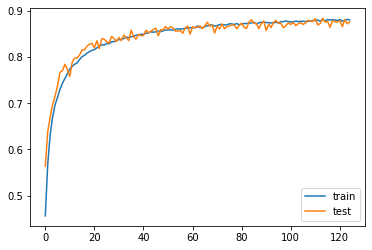

In [21]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()